<a href="https://colab.research.google.com/github/BSteiner1/MultiDeepQLearn/blob/main/MultiDeepQLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import random
import matplotlib.pyplot as plt

### Define some of the variables as given in the paper

In [ ]:
# Define the demand function parameters
a1 = 2
a2 = 2
# Outside good
a0 = 0

In [ ]:

# Marginal cost
c = 1
# Price sensitivity
mu = 0.1
# Epsilon-Greedy Strategy
epsilon = 0.1

### Calculate demand given current prices

In [ ]:
# Function to calculate the logit demand for a given product
def logit_demand(price, other_price):
    q = np.exp((2 - price)/mu) / (np.exp((2 - other_price)/mu)) # + np.exp(0/mu))
    return q

### Epsilon-Greedy Action Selection

In [ ]:
def epsilon_greedy_action_selection(net, state, epsilon, t):
    #if np.random.rand() < epsilon:
    if np.random.rand() < np.exp(-0.0005*t):
        #print("PROB: ", np.exp(-0.001*t))
        # Exploration
        return random.choice([i for i in range(num_prices)])
    else:
        # Exploitation
        #print("EXPLOIT")
        with torch.no_grad():
            q_values = net(state)
            return q_values.argmax().item()

### Determine profits from current prices

In [ ]:
def simulate_environment(prices):
    price1, price2 = prices[0], prices[1]

    # Calculate the demand for each business
    demand1 = logit_demand(price1, price2)
    demand2 = logit_demand(price2, price1)

    # Calculate the revenue and profit for each product
    revenue1 = price1 * demand1
    revenue2 = price2 * demand2

    # Assuming the agents have 0 marginal cost
    profit1 = revenue1 - demand1 * c
    profit2 = revenue2 - demand2 * c

    #print("DEMAND: ", demand1)

    return [profit1, profit2]

### Discretise the action space

In [ ]:
# Number of prices to choose from
num_prices = 40
price_options = [round(0.05*i, 2) for i in range(1, num_prices+1)]

### Define parameters in the learning process

In [ ]:
num_episodes = 10000
learning_rate = 0.001
discount_factor = 0.99
epsilon = 0.1
max_steps_per_episode = 20

### Dimensions of the network

In [ ]:
state_size = 4  # Size of state (current + memory of 1)
hidden_size = 216 # Size of the hidden layer
action_size = num_prices  # Number of price options

net_dimensions = [state_size, hidden_size, action_size]

### Training Loop

In [ ]:
def train_q_learning(num_episodes, learning_rate, discount_factor, epsilon, max_steps_per_episode, net_dimensions):

    # Assign network dimensions
    state_size, hidden_size, action_size = net_dimensions

    #Create the Q-value models for each agent
    q_value_model_agent1 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )
    q_value_model_agent2 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )

    optimizer_agent1 = optim.Adam(q_value_model_agent1.parameters(), lr=learning_rate)
    optimizer_agent2 = optim.Adam(q_value_model_agent2.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    profit1 = []

    start_time = time.time()

    for episode in range(num_episodes):
      if episode%100 == 0:
        print("Episode: ", episode)

      # Initialize with random prices for both businesses
      price_business1 = random.choice(price_options)
      price_business2 = random.choice(price_options)

      state = torch.tensor([price_business1, price_business2, 0, 0], dtype=torch.float32)

      episode_actions = []
      episode_profit = 0
      step = 0
      while step < max_steps_per_episode:
        # Agent 1 chooses action based on the current state and epsilon-greedy strategy
        action_agent1 = epsilon_greedy_action_selection(q_value_model_agent1, state, epsilon, episode)
        episode_actions.append(action_agent1)

        # Agent 2 chooses action based on the current state and epsilon-greedy strategy
        action_agent2 = epsilon_greedy_action_selection(q_value_model_agent2, state, epsilon, episode)

        # Combine the chosen actions to form the joint action (prices for both agents)
        joint_action = [price_options[action_agent1], price_options[action_agent2]]

        # Simulate the environment based on the joint action and calculate profit
        rewards = simulate_environment(joint_action)
        episode_profit += rewards[0]

        # Create the next state tensor from the new prices
        last_state = state.tolist()[:2]
        next_state = torch.tensor(joint_action + last_state, dtype=torch.float32)

        # Calculate the Q-value target for the current state-action pair
        with torch.no_grad():
            q_value_target_agent1 = torch.tensor(rewards[0], dtype=torch.float32) + discount_factor * torch.max(q_value_model_agent1(next_state))
            q_value_target_agent2 = torch.tensor(rewards[1], dtype=torch.float32) + discount_factor * torch.max(q_value_model_agent2(next_state))

        # Calculate the Q-value prediction for the current state-action pair
        q_value_prediction_agent1 = q_value_model_agent1(state)[action_agent1]
        q_value_prediction_agent2 = q_value_model_agent2(state)[action_agent2]

        # Compute the loss and perform backpropagation for each agent
        optimizer_agent1.zero_grad()
        loss_agent1 = criterion(q_value_prediction_agent1, q_value_target_agent1)
        loss_agent1.backward()
        optimizer_agent1.step()

        optimizer_agent2.zero_grad()
        loss_agent2 = criterion(q_value_prediction_agent2, q_value_target_agent2)
        loss_agent2.backward()
        optimizer_agent2.step()

        # Update the state for the next iteration
        state = next_state
        step += 1

      profit1.append(episode_profit)

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_per_episode = elapsed_time/num_episodes
    print("Total Number of Episodes:", num_episodes)
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Average Time per Episode: {time_per_episode:.3f} seconds")

    return q_value_model_agent1, q_value_model_agent2, profit1

In [ ]:
trained_model_agent1, trained_model_agent2, profit1 = train_q_learning(num_episodes, learning_rate, discount_factor, epsilon, max_steps_per_episode, net_dimensions)

Episode:  0
Episode:  100
Episode:  200
Episode:  300
Episode:  400
Episode:  500
Episode:  600
Episode:  700
Episode:  800
Episode:  900
Episode:  1000
Episode:  1100
Episode:  1200
Episode:  1300
Episode:  1400
Episode:  1500
Episode:  1600
Episode:  1700
Episode:  1800
Episode:  1900
Episode:  2000
Episode:  2100
Episode:  2200
Episode:  2300
Episode:  2400
Episode:  2500
Episode:  2600
Episode:  2700
Episode:  2800
Episode:  2900
Episode:  3000
Episode:  3100
Episode:  3200
Episode:  3300
Episode:  3400
Episode:  3500
Episode:  3600
Episode:  3700
Episode:  3800
Episode:  3900
Episode:  4000
Episode:  4100
Episode:  4200
Episode:  4300
Episode:  4400
Episode:  4500
Episode:  4600
Episode:  4700
Episode:  4800
Episode:  4900
Episode:  5000
Episode:  5100
Episode:  5200
Episode:  5300
Episode:  5400
Episode:  5500
Episode:  5600
Episode:  5700
Episode:  5800
Episode:  5900
Episode:  6000
Episode:  6100
Episode:  6200
Episode:  6300
Episode:  6400
Episode:  6500
Episode:  6600
Episode

### Visualise the learning process

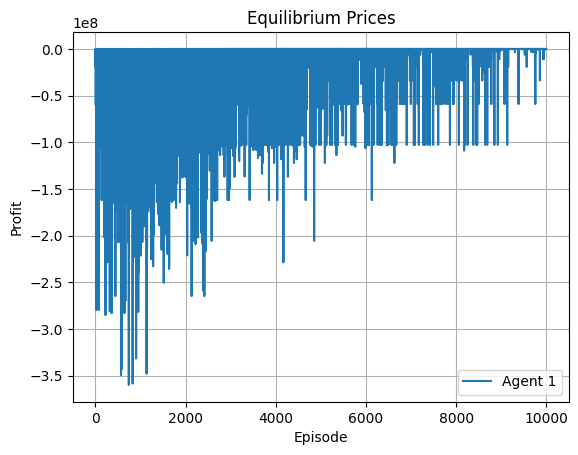

In [ ]:
episodes = range(len(profit1))  # Assuming both lists have the same length (number of episodes)

plt.plot(episodes, profit1, label='Agent 1')

plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Equilibrium Prices')
plt.legend()
plt.grid(True)
plt.show()

### Play the agents against each other in a one-off repeated game

In [ ]:
def play_agents(agent1_model, agent2_model, max_iterations):

    prices1, prices2 = [], []
    profit1, profit2 = 0, 0

    # Start with random prices for both businesses
    price_agent1 = random.choice(price_options)
    price_agent2 = random.choice(price_options)

    start_action = [price_agent1, price_agent2]

    prices1.append(price_agent1)
    prices2.append(price_agent2)

    p1 = simulate_environment(start_action)[0]
    p2 = simulate_environment(start_action)[1]

    profit1 += p1
    profit2 += p2

    state = torch.tensor([price_agent1, price_agent2, 0, 0], dtype=torch.float32)

    for _ in range(max_iterations):
        # Get the Q-values for both agents from their models
        q_values_agent1 = agent1_model(state)
        q_values_agent2 = agent2_model(state)

        # Choose action based on the learned policy
        action_agent1 = torch.argmax(q_values_agent1).item()
        action_agent2 = torch.argmax(q_values_agent2).item()

        # Get the price from the action
        price_agent1 = price_options[action_agent1]
        price_agent2 = price_options[action_agent2]

        joint_action = [price_agent1, price_agent2]

        p1 = simulate_environment(joint_action)[0]
        p2 = simulate_environment(joint_action)[1]

        # Update the state
        last_state = state.tolist()[:2]
        state = torch.tensor(joint_action + last_state, dtype=torch.float32)

        # Keep track of history
        prices1.append(price_agent1)
        prices2.append(price_agent2)
        profit1 += p1
        profit2 += p2

    return prices1, prices2, profit1, profit2

In [ ]:
max_iterations = 19 # Random initialisation gives 20 repetitions

### Outcome of the game

In [ ]:
# Play the agents against each other and observe the equilibrium prices
agent1_prices, agent2_prices, agent1_profit, agent2_profit = play_agents(trained_model_agent1, trained_model_agent2, max_iterations)

print("Agent 1 Prices: ", agent1_prices)
print("Agent 2 Prices: ", agent2_prices)
print("Agent 1 Profit: ", np.round(agent1_profit, 3))
print("Agent 2 Profit: ", np.round(agent2_profit, 3))

Agent 1 Prices:  [1.45, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Agent 2 Prices:  [1.45, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9]
Agent 1 Profit:  7.44
Agent 2 Profit:  46.933


### A function to determine the next action given any combination of current and previous actions

In [ ]:
def inspect_agent(price1, price2, last_price1, last_price2):
  state_agent1 = torch.tensor([price1, price2, last_price1, last_price2], dtype=torch.float32)

  # Get the Q-values for Agent 1 in state
  q_values_agent1 = trained_model_agent1(state_agent1)

  # Convert the Q-values tensor to a NumPy array for easier inspection
  q_values_agent1 = q_values_agent1.detach().numpy()

  print("Q-values for Agent 1 in state ", (price1, price2, last_price1, last_price2), ":\n\n", q_values_agent1)

  # Select action with highest Q-value
  action = q_values_agent1.argmax()
  print("\nNext Action: ", price_options[action])

In [ ]:
inspect_agent(2, 1.95, 2, 1.95)

Q-values for Agent 1 in state  (2, 1.95, 2, 1.95) :

 [-3262.3381  -3126.772   -3389.4426  -3449.1143  -3055.075   -3040.1018
 -3211.308   -3173.7136  -2654.6128  -3191.705   -3398.6553  -2493.319
 -2599.408   -2413.3027  -1237.329     212.89067  2154.6396   4575.7925
  7045.3965   7607.3447   7578.561    7788.0044   7683.6646   8119.4634
  8099.9175   8322.412    8261.493    8268.006    8215.499    8448.671
  8429.8125   8402.891    8523.886    9034.32     8790.854    8681.731
  8875.911    8608.458    8791.973    9299.866  ]

Next Action:  2.0


In [ ]:
np.exp(-0.1)

0.9048374180359595